## Imports

In [1]:
from profiler import *
import pandas as pd
import numpy as np
import seaborn as sns
import os, sys,  signal, time
import subprocess
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict

In [2]:
%matplotlib inline
sns.set(style="ticks", color_codes=True)

## Performance Counters

Performance counters are special hardware registers available on most modern CPUs. These registers count the number of certain types of hw events: such as instructions executed, cachemisses suffered, or branches mis-predicted - without slowing down the kernel or applications. These registers can also trigger interrupts when a threshold number of events have passed - and can thus be used to profile the code that runs on that CPU.


## Reading Performance counters

### rdmsr: 
Reads the contents of a 64-bit model specific register (MSR) specified in the ECX register into registers EDX:EAX. This instruction must be executed at privilege level 0 or in real-address mode

### rdpmc
Is slightly faster that the equivelent rdmsr instruction.  rdpmc can
also be configured to allow access to the counters from userspace, without
being priviledged.


### From userspace (Linux)
The Linux Performance Counter subsystem provides an abstraction of these hardware capabilities. It provides per task and per CPU counters, counter groups, and it provides event capabilities on top of those.  It provides "virtual" 64-bit counters, regardless of the width of the
underlying hardware counters. Performance counters are accessed via special file descriptors. There's one file descriptor per virtual counter used. The special file descriptor is opened via the perf_event_open() system call. These system call do not use rdpmc but rdpmc is not necessarily faster than other methods for reading event values.

TODO: libpfm

### Minimal example perf_event_open
```c++
#include <iostream>

#include <linux/perf_event.h>
#include <asm/unistd.h>
#include <sys/ioctl.h>
#include <memory.h> 
#include <unistd.h>

using namespace std;

int main(int argc, char **argv)
{
   long long count;
   int fd;
   
   // Configure the event to open
   struct perf_event_attr pe;
   memset(&pe, 0, sizeof(struct perf_event_attr));
   pe.type = PERF_TYPE_HARDWARE;
   pe.size = sizeof(struct perf_event_attr);
   pe.config = PERF_COUNT_HW_INSTRUCTIONS;
   
   // Call perf_event_open and create the fd
   if ((fd = syscall(__NR_perf_event_open, &pe, 0, -1, -1, 0)) == -1)
      return -1;
    
   // Reset the counter and enable
   ioctl(fd, PERF_EVENT_IOC_RESET, 0);
   ioctl(fd, PERF_EVENT_IOC_ENABLE, 0);

   cout << "Measuring instruction count for this cout" << endl;

   ioctl(fd, PERF_EVENT_IOC_DISABLE, 0);
   read(fd, &count, sizeof(long long));

   cout << "Used " << count << " instructions" << endl;
}
```

## API comparation

There are only a few APIs that allow access to these counters, and many of them are poorly documented, unstable, or unavailable. In addition, performance metrics may have different definitions and different programming interfaces on different platforms.
    
 * Linux perf (http://man7.org/linux/man-pages/man2/perf_event_open.2.html)
 * pfmon c (http://perfmon2.sourceforge.net/man/pfmon.html)
 * pfmon python (http://perfmon2.sourceforge.net/man/pfmon.html)
 * PAPI c (https://icl.cs.utk.edu/projects/papi/wiki/Main_Page)
 * PAPI python (https://flozz.github.io/pypapi/install.html)



## Benchmarks

#### Precise instructions number
```assembly
section .data
    msg db      "hello, world!"

section .text
    global _start
_start:
    push    rbp 
    mov     rbp, rsp 
    mov     DWORD[rbp-0x4], 0x0

    loop:
    mov     rax, 1
    mov     rdi, 1
    mov     rsi, msg 
    mov     rdx, 13
    syscall
    add     DWORD[rbp-0x4], 1
    cmp     DWORD[rbp-0x4], 100000
    jne     loop
    
    pop rbp
    mov    rax, 60
    mov    rdi, 0
    syscall

; 3 + 8*1000 + 4 = 8007 instructions
```
Mounted with:
```bash
nasm -f elf64 hello.asm -o hello.o && ld hello.o -o hello
```

#### Simple large loop with linking
```c++
#include <iostream>
#include <math.h>

using namespace std;

int main()
{
    double x= 0;
    for(int i=1; i<99999; i++)
    {
        for(int j=1; j<99; j++)
        {
            x=pow(i,j)+sqrt(j)*sqrt(j);
        }   
    }
    return x;
}
```

Compiled with:
```bash
g++ simple_loop.cpp -o simple_dynamic_ld
g++ -static simple_loop.cpp -o simple_static_ld
```

## Measuring for 100 executions:
   * TOTAL INSTRUCTIONS
   * BRANCH INSTRUCTIONS
   * BRANCH MISPREDICT
   * TOTAL CACHE READ L3

In [65]:
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
def run_python(pname):
    #pip install python_papi
    print("python-papi",pname)
    from pypapi import papi_low as papi
    from pypapi import events

    papi.library_init()
    total=[]
    cont= 0

    for i in range(100):
        try:
            evs= papi.create_eventset()
            papi.add_event(evs, events.PAPI_TOT_INS)
            papi.add_event(evs, events.PAPI_BR_INS)
            papi.add_event(evs, events.PAPI_BR_MSP)
            papi.add_event(evs, events.PAPI_L3_TCR)

            p= subprocess.Popen([pname], stdout= subprocess.PIPE)
            os.kill(p.pid, signal.SIGSTOP)
            papi.attach(evs, p.pid)
            papi.start(evs)
            os.kill(p.pid, signal.SIGCONT)
            p.wait()
            result= papi.stop(evs)
            total.append(result)
            papi.cleanup_eventset(evs)
            papi.destroy_eventset(evs)
            sys.stdout.write('.')
            sys.stdout.flush()
            cont+=1
            # print(result)
        except Exception as e:
            print("Error on", cont)
            print(e)
            pass

    total= np.asarray(total)
    print()
    print('Mean',total.mean(axis=0))
    print('Std',total.std(axis=0))
    return total.mean(axis=0), total.std(axis=0)


def run_all(bench, prog):
    m= []
    print(bench, prog)
    for i in range(100):
        sys.stdout.write('.')
        sys.stdout.flush()
        data= subprocess.Popen([bench,prog],stdout=subprocess.PIPE).stdout.readlines()
        n= []
        names= []
        for c in data:
            aux= str(c)
            names.append(str(aux.split(':')[0]))
            n.append(int(str(aux.split(':')[1])[:-3]))
        m.append(n)
    df= pd.DataFrame(m, columns=names)
    print()
    print('Mean', df.mean().values)
    print('Std', df.std().values)
    return df.mean().values, df.std().values

In [64]:
df= []
for p in ['hello','simple_static_ld','simple_dynamic_ld']:
    print('')
    print('')
    print("Program",p)
    if p  != 'hello': # too fast
        papi_python_mean, papi_python_std= run_python('./benchs/'+p)
    else: papi_python_mean, papi_python_std= None,None
    linux_perf_mean, linux_perf_std= run_all('./api_tests/linux_perf', 'benchs/'+p)
    papi_perf_mean, papi_perf_std= run_all('./api_tests/papi_perf', 'benchs/'+p)
    df.append([papi_python_mean, papi_python_std, linux_perf_mean, linux_perf_std, papi_perf_mean, papi_perf_std])
df= pd.DataFrame(df,columns=['papi_python_mean', 'papi_python_std', 'linux_perf_mean', 
                             'linux_perf_std', 'papi_perf_mean', 'papi_perf_std'])



Program hello
./api_tests/linux_perf benchmarks/hello
....................................................................................................
[ 800053.10000  200015.32000  4.28000  37.43000]
[ 102.76987  23.65616  7.57465  46.58895]
./api_tests/papi_perf benchmarks/hello
....................................................................................................
[ 800012.15000  200006.15000  1.48000  61.53000]
[ 2.43450  2.43450  1.67260  79.54002]


Program simple_static_ld
....................................................................................................
[ 3208825194.36000  547062717.35000  302093.02000  8524.68000]
[ 113474.58217  19951.05635  8226.58315  8123.22302]
./api_tests/linux_perf benchmarks/simple_static_ld
....................................................................................................
[ 3208969026.02000  547095163.58000  301272.83000  4716.76000]
[ 108.92987  65.48671  1971.18889  3574.15419]
./api_tests/papi_p

In [58]:
df['papi_python_mean'][0]= [0,0,0,0]
df['papi_python_std'][0]= [0,0,0,0]
display( np.array((df['linux_perf_mean']-df['papi_perf_mean'])/df['linux_perf_mean']*100) )
display( np.array((df['linux_perf_mean']-df['papi_python_mean'])/df['linux_perf_mean']*100) )
display( np.array((df['papi_perf_mean']-df['papi_python_mean'])/df['linux_perf_mean']*100) )
#df

array([array([ 0.00136,  0.00118,  30.20833, -81.12392]),
       array([-0.00000, -0.00000, -0.06471, -39.12552]),
       array([ 0.00000,  0.00000, -0.12363, -32.12942])], dtype=object)

array([array([ 100.00000,  100.00000,  100.00000,  100.00000]),
       array([ 0.00417,  0.00572,  0.13544, -35.99606]),
       array([ 0.00391,  0.00461,  0.25289, -5.06716])], dtype=object)

array([array([ 99.99864,  99.99882,  69.79167,  181.12392]),
       array([ 0.00417,  0.00572,  0.20015,  3.12946]),
       array([ 0.00391,  0.00461,  0.37651,  27.06226])], dtype=object)

## Results

|     API     | Sync start | Attach to pid | Variance | Overhead | Sampling method                   | Control |
|:-----------:|:----------:|:-------------:|----------|----------|-----------------------------------|---------|
| PAPI python |     no     |      yes      | HIGH     |  MEDIUM  |                Time               |   LOW   |
|    PAPI c   |     yes    |      yes      | LOW      |    LOW   |         Time,interruption         |  MEDIUM |
|  Linux perf |     yes    |      yes      | MEDIUM   |    LOW   |  Time,interruption,wait for event |   HIGH  |

## Sampling methods comparison

### Method interruption:
Each n events a signal is generated and call the predefined function.
### Method wait:
Wait for the event file descriptor set a flag after n events.
### Time
Sample every n ms

In [61]:
p= subprocess.Popen(['./tests/sample_teste', 'benchmarks/hello'], stdout=subprocess.PIPE)
for l in p.stdout.readlines(): print(str(l))

b'....................................................................................................\n'
b'Sampling method Interruption : 793084 +- 5785.85  nsamples 23.98\n'
b'Sampling method Wait : 662745 +- 9089.77  nsamples 22.19\n'
b'Sampling method Time : 799999 +- 116.394  nsamples 24.06\n'


In [4]:
p= subprocess.Popen(['./tests/sample_teste', 'benchmarks/hello'], stdout=subprocess.PIPE)
for l in p.stdout.readlines(): print(str(l))

b'..............................\n'
b'Sampling method Interruption : 760671 +- 50227.7  nsamples 237.233\n'
b'Sampling method Wait : 76538.6 +- 4311.31  nsamples 19.6333\n'
b'Sampling method Time : 798449 +- 154.595  nsamples 223.9\n'


In [5]:
p= subprocess.Popen(['./tests/sample_teste', 'benchmarks/simple_static_ld'], stdout=subprocess.PIPE)
for l in p.stdout.readlines(): print(str(l))

b'..............................\n'
b'Sampling method Interruption : 3.16681e+09 +- 1.19086e+07  nsamples 309.867\n'
b'Sampling method Wait : 5.62848e+06 +- 168344  nsamples 1\n'
b'Sampling method Time : 3.20784e+09 +- 264495  nsamples 194.933\n'


Sampling over time demonstrate to be the less agressive method

## Tools comparation
    * Perf
    * gprof
    * myprof


TODO

## Gathering performance counters

## Helper functions

In [3]:
flat_list= lambda x: [ g for f in x for g in f ]
double_list= lambda x: [[g] for g in x]
split_n= lambda x, n: [x[i:i + n] for i in range(0, len(x), n)]

def run_program(pargs, to_monitor, n=30, sample_period=0.05, reset_on_sample= True):
    """
        Run the program multiple times
    """
    try:
        all_data= []
        for i in tqdm(range(n)):
            program= Profiler(program_args=pargs, events_groups=to_monitor)
            data= program.run(sample_period=sample_period,reset_on_sample=reset_on_sample)
            all_data.append(data)
    except RuntimeError as e:
        print(e.args[0])
    return all_data

def smooth_df(runs, cols_names):
    """
        Resume multiple runs in one dataframe
        
        Remove outsamples using median split
        Average results and calculate standard deviation
    """
    count_shapes= defaultdict(lambda:0)
    for r in runs:
        count_shapes[np.shape(r)]+=1
    moda_shape= max(count_shapes,key=count_shapes.get)
    
    print("Moda shape counts {:.2f}%".format(count_shapes[moda_shape]/sum(count_shapes.values())*100))
    data_moda= [d for d in runs if np.shape(d) == moda_shape]

    big_l= []
    for r in data_moda:
        big_l.append(np.array(r).reshape(-1))
    big_l= np.asarray(big_l)
    
    med_avg= []
    std_avg= []
    for s in range(big_l.shape[1]):
        median= np.sort(big_l[:,s])[3:-3]
        med_avg.append(median.mean())
        std_avg.append(median.std())
    
    med_avg= np.asarray(med_avg)
    std_avg= np.asarray(std_avg)
    
    med_avg= pd.DataFrame(med_avg.reshape(moda_shape), columns=cols_names)
    std_avg= pd.DataFrame(std_avg.reshape(moda_shape), columns=cols_names)
    
    
    q= std_avg.values/med_avg.values
    print("AVG 68% samples error", np.nanmean(q))
    print("AVG 99% stds error", np.nanmean(3*q))
    print("MAX 68% stds error", np.nanmax(q))
    print("MAX 99% stds error", np.nanmax(3*q))
    
    return med_avg, std_avg

## Events specifications

In [4]:
all_events= get_event_description()
software_events= [e[0] for e in all_events if 'PERF_COUNT_SW' in e[0]]
hardware_events= [e[0] for e in all_events if 'PERF_COUNT_HW' in e[0]]
mem_events=[e[0] for e in all_events if 'MEM' in e[0] or 'CACHE' in e[0]]
rapl_events=['SYSTEMWIDE:'+e[0] for e in all_events if 'RAPL' in e[0]]
hw_groups= split_n(hardware_events, 5)

# Interrest
hw_events= double_list(['PERF_COUNT_HW_INSTRUCTIONS','PERF_COUNT_HW_BRANCH_INSTRUCTIONS','FP_COMP_OPS_EXE:X87',
                       'PERF_COUNT_HW_BRANCH_MISSES', 'PERF_COUNT_HW_CACHE_MISSES'])
mem_events= double_list(['MEM_UOPS_RETIRED:ALL_LOADS', 'MEM_UOPS_RETIRED:ALL_STORES'])
sw_events= [['PERF_COUNT_SW_CPU_CLOCK','PERF_COUNT_SW_PAGE_FAULTS','PERF_COUNT_SW_CONTEXT_SWITCHES',
                       'PERF_COUNT_SW_CPU_MIGRATIONS','PERF_COUNT_SW_PAGE_FAULTS_MAJ']]
rapl_events= double_list(rapl_events)
to_monitor= hw_events+mem_events+sw_events+rapl_events

for ev in flat_list(to_monitor):
    ev_split= ev.split(':')
    name= ev_split[1] if 'SYSTEMWIDE' in ev else ev_split[0]
    print( '%s: %s'%(name, get_event_description(name)[0][1]))
    if len(ev_split) > 1:
        for att in get_event_attrs(name):
            print('\t %s: %s'%(att[0],att[1]))

PERF_COUNT_HW_INSTRUCTIONS: PERF_COUNT_HW_INSTRUCTIONS
PERF_COUNT_HW_BRANCH_INSTRUCTIONS: PERF_COUNT_HW_BRANCH_INSTRUCTIONS
FP_COMP_OPS_EXE: Counts number of floating point events
	 X87: Number of X87 uops executed
	 SSE_FP_PACKED_DOUBLE: Number of SSE double precision FP packed uops executed
	 SSE_FP_SCALAR_SINGLE: Number of SSE single precision FP scalar uops executed
	 SSE_PACKED_SINGLE: Number of SSE single precision FP packed uops executed
	 SSE_SCALAR_DOUBLE: Number of SSE double precision FP scalar uops executed
	 e: edge level (may require counter-mask >= 1)
	 i: invert
	 c: counter-mask in range [0-255]
	 t: measure any thread
	 u: monitor at user level
	 k: monitor at kernel level
	 period: sampling period
	 freq: sampling frequency (Hz)
	 excl: exclusive access
	 mg: monitor guest execution
	 mh: monitor host execution
	 cpu: CPU to program
	 pinned: pin event to counters
PERF_COUNT_HW_BRANCH_MISSES: PERF_COUNT_HW_BRANCH_MISSES
PERF_COUNT_HW_CACHE_MISSES: PERF_COUNT_HW_CACHE

<h1>
    <a href="http://uops.info/table.html">UOPS- micro operations</a>
</h1>
<img src="pipeline.png" width=340> </img>
<p></p>

<img src="https://upload.wikimedia.org/wikipedia/commons/8/8c/Standard_deviation_diagram.svg" width=640px></img>

In [5]:
to_monitor

[['PERF_COUNT_HW_INSTRUCTIONS'],
 ['PERF_COUNT_HW_BRANCH_INSTRUCTIONS'],
 ['FP_COMP_OPS_EXE:X87'],
 ['PERF_COUNT_HW_BRANCH_MISSES'],
 ['PERF_COUNT_HW_CACHE_MISSES'],
 ['MEM_UOPS_RETIRED:ALL_LOADS'],
 ['MEM_UOPS_RETIRED:ALL_STORES'],
 ['PERF_COUNT_SW_CPU_CLOCK',
  'PERF_COUNT_SW_PAGE_FAULTS',
  'PERF_COUNT_SW_CONTEXT_SWITCHES',
  'PERF_COUNT_SW_CPU_MIGRATIONS',
  'PERF_COUNT_SW_PAGE_FAULTS_MAJ'],
 ['SYSTEMWIDE:RAPL_ENERGY_CORES'],
 ['SYSTEMWIDE:RAPL_ENERGY_PKG'],
 ['SYSTEMWIDE:RAPL_ENERGY_DRAM']]

```asm
section .text
    global _start
_start:
    push    rbp ; store rbp on the stack

    mov    rax, 60 ; syscall exit
    mov    rdi, 0 ; param 0
    syscall ; exit(0)

; 4 instructions
; 1 memory store
```

In [7]:
data= run_program(pargs=['benchs/store'],to_monitor=to_monitor,n=100,reset_on_sample=False)
avg_df, std_df= smooth_df(data, flat_list(to_monitor))
avg_df[['MEM_UOPS_RETIRED:ALL_STORES','PERF_COUNT_HW_INSTRUCTIONS']]

100%|██████████| 100/100 [00:06<00:00, 15.48it/s]
/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


Moda shape counts 100.00%
AVG 68% samples error 0.1442050581361845
AVG 99% stds error 0.4326151744085535
MAX 68% stds error 0.49908370860279727
MAX 99% stds error 1.4972511258083918


,MEM_UOPS_RETIRED:ALL_STORES,PERF_COUNT_HW_INSTRUCTIONS
0,1.0,5.0
1,1.0,5.0


```asm
section .data
    a: dq 123.45  ;declare quad word (double precision)

section .text
    global _start
_start:
    
    fld qword [a]   ;load a into st0
    fmul st0, st0   ;st0 = a * a = a^2

    mov    rax, 60
    mov    rdi, 0
    syscall

; 5 instructions
; 1 memory load
; 2 operations on fpu
```

In [9]:
data= run_program(pargs=['benchs/float'],to_monitor=to_monitor,n=100,reset_on_sample=False)
avg_df, std_df= smooth_df(data, flat_list(to_monitor))
avg_df[['FP_COMP_OPS_EXE:X87','PERF_COUNT_HW_INSTRUCTIONS']]

100%|██████████| 100/100 [00:06<00:00, 16.03it/s]

Moda shape counts 100.00%
AVG 68% samples error 0.1534032446714958
AVG 99% stds error 0.4602097340144875
MAX 68% stds error 0.45649060484428744
MAX 99% stds error 1.3694718145328624



/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


,FP_COMP_OPS_EXE:X87,PERF_COUNT_HW_INSTRUCTIONS
0,2.031915,7.0
1,2.031915,7.0


## Sampling counters over time

In [33]:
avg_df.columns

Index(['PERF_COUNT_HW_INSTRUCTIONS', 'PERF_COUNT_HW_BRANCH_INSTRUCTIONS',
       'FP_COMP_OPS_EXE:X87', 'PERF_COUNT_HW_BRANCH_MISSES',
       'PERF_COUNT_HW_CACHE_MISSES', 'MEM_UOPS_RETIRED:ALL_LOADS',
       'MEM_UOPS_RETIRED:ALL_STORES', 'PERF_COUNT_SW_CPU_CLOCK',
       'PERF_COUNT_SW_PAGE_FAULTS', 'PERF_COUNT_SW_CONTEXT_SWITCHES',
       'PERF_COUNT_SW_CPU_MIGRATIONS', 'PERF_COUNT_SW_PAGE_FAULTS_MAJ',
       'SYSTEMWIDE:RAPL_ENERGY_CORES', 'SYSTEMWIDE:RAPL_ENERGY_PKG',
       'SYSTEMWIDE:RAPL_ENERGY_DRAM'],
      dtype='object')

In [25]:
data= run_program(pargs=['benchs/hello'],to_monitor=to_monitor,n=30,reset_on_sample=True,sample_period=0.01)
avg_df, std_df= smooth_df(data, flat_list(to_monitor))
display(avg_df)
loss= (800007-avg_df['PERF_COUNT_HW_INSTRUCTIONS'].sum())/800007
print("Lost {} instructions of 800007 {:.3f}%".format(800007-avg_df['PERF_COUNT_HW_INSTRUCTIONS'].sum(), loss*100))

Moda shape counts 99.00%
AVG 68% samples error 0.5929821844754156
AVG 99% stds error 1.7789465534262467
MAX 68% stds error 6.745368781616021
MAX 99% stds error 20.23610634484806


/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


,PERF_COUNT_HW_INSTRUCTIONS,PERF_COUNT_HW_BRANCH_INSTRUCTIONS,FP_COMP_OPS_EXE:X87,PERF_COUNT_HW_BRANCH_MISSES,PERF_COUNT_HW_CACHE_MISSES,MEM_UOPS_RETIRED:ALL_LOADS,MEM_UOPS_RETIRED:ALL_STORES,PERF_COUNT_SW_CPU_CLOCK,PERF_COUNT_SW_PAGE_FAULTS,PERF_COUNT_SW_CONTEXT_SWITCHES,PERF_COUNT_SW_CPU_MIGRATIONS,PERF_COUNT_SW_PAGE_FAULTS_MAJ,SYSTEMWIDE:RAPL_ENERGY_CORES,SYSTEMWIDE:RAPL_ENERGY_PKG,SYSTEMWIDE:RAPL_ENERGY_DRAM
0,69637.795699,17416.290323,0.258065,0.344086,5.494624,40552.677419,8720.688172,1.004731e+07,1.0,0.0,0.0,0.0,9.073607e+08,1.354862e+09,0.0
1,79618.010753,19902.172043,0.000000,0.000000,0.322581,45904.333333,9948.870968,1.007955e+07,0.0,0.0,0.0,0.0,9.929169e+08,1.438044e+09,0.0
2,85183.451613,21299.956989,0.000000,0.000000,0.182796,51827.741935,10648.741935,1.007722e+07,0.0,0.0,0.0,0.0,1.141430e+09,1.583410e+09,0.0
3,86257.806452,21568.774194,0.000000,0.000000,0.107527,48985.064516,10782.849462,1.008708e+07,0.0,0.0,0.0,0.0,1.013452e+09,1.453659e+09,0.0
4,86138.118280,21538.924731,0.000000,0.000000,0.053763,49029.419355,10767.193548,1.008916e+07,0.0,0.0,0.0,0.0,9.127375e+08,1.354705e+09,0.0
5,86105.000000,21531.053763,0.000000,0.000000,0.043011,48871.225806,10763.763441,1.009234e+07,0.0,0.0,0.0,0.0,9.193552e+08,1.361222e+09,0.0
6,86138.236559,21538.784946,0.000000,0.000000,0.032258,48921.741935,10767.956989,1.009297e+07,0.0,0.0,0.0,0.0,9.162053e+08,1.355390e+09,0.0
7,86000.612903,21504.516129,0.000000,0.000000,0.032258,48981.978495,10750.408602,1.009308e+07,0.0,0.0,0.0,0.0,8.920845e+08,1.331112e+09,0.0
8,86242.591398,21565.118280,0.000000,0.000000,0.075269,48825.333333,10780.892473,1.009864e+07,0.0,0.0,0.0,0.0,9.157846e+08,1.356438e+09,0.0
9,48987.817204,12245.870968,0.000000,1.000000,0.021505,27861.473118,6113.688172,5.756180e+06,0.0,0.0,0.0,0.0,8.087502e+08,1.249765e+09,0.0


Lost -302.44086021510884 instructions of 800007 -0.038%


/home/vitor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


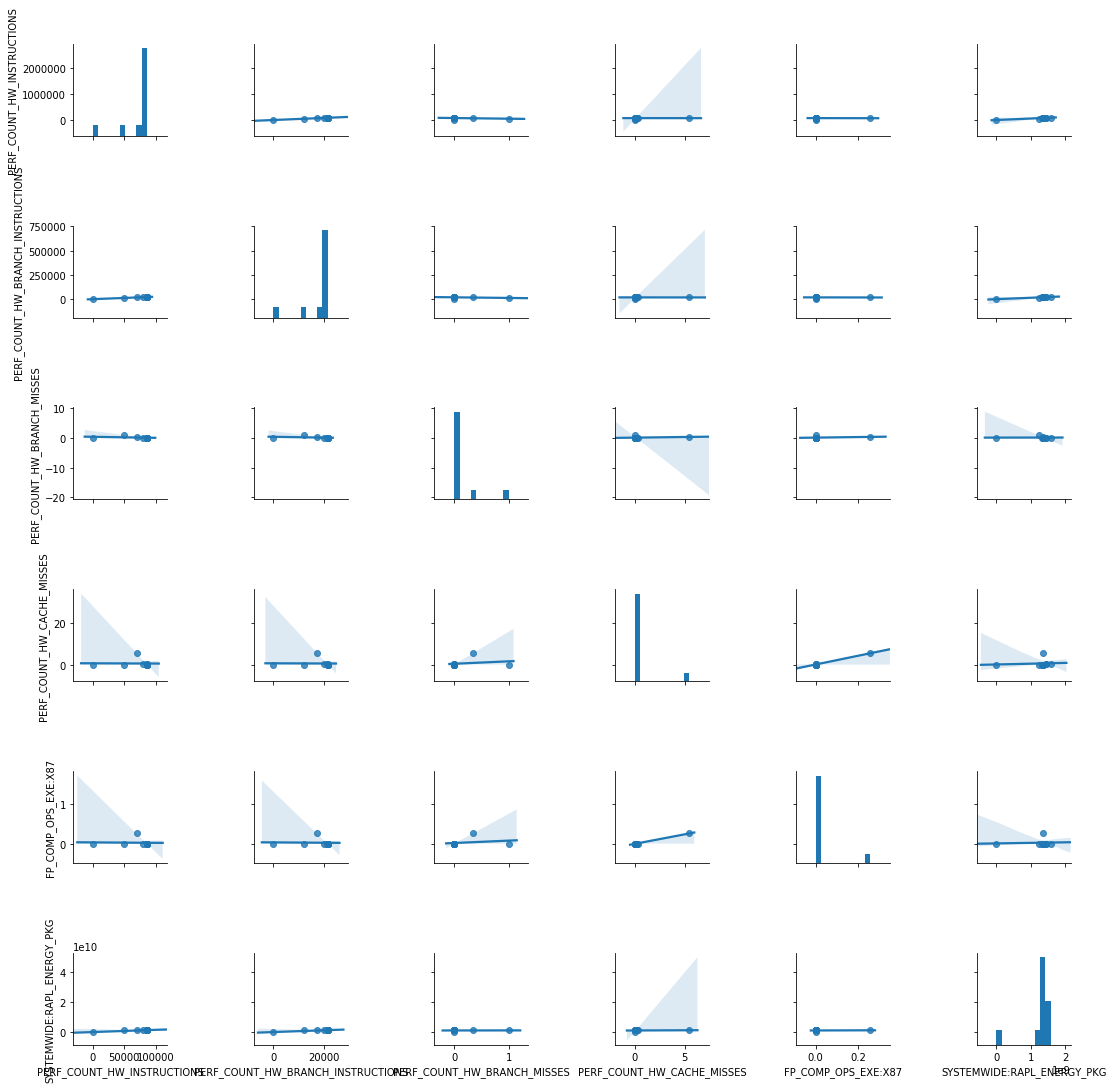

In [36]:
g = sns.pairplot(avg_df, vars=["PERF_COUNT_HW_INSTRUCTIONS", 
                               "PERF_COUNT_HW_BRANCH_INSTRUCTIONS", 
                               "PERF_COUNT_HW_BRANCH_MISSES",
                               "PERF_COUNT_HW_CACHE_MISSES",
                               "FP_COMP_OPS_EXE:X87",
                               "SYSTEMWIDE:RAPL_ENERGY_PKG"], kind="reg")

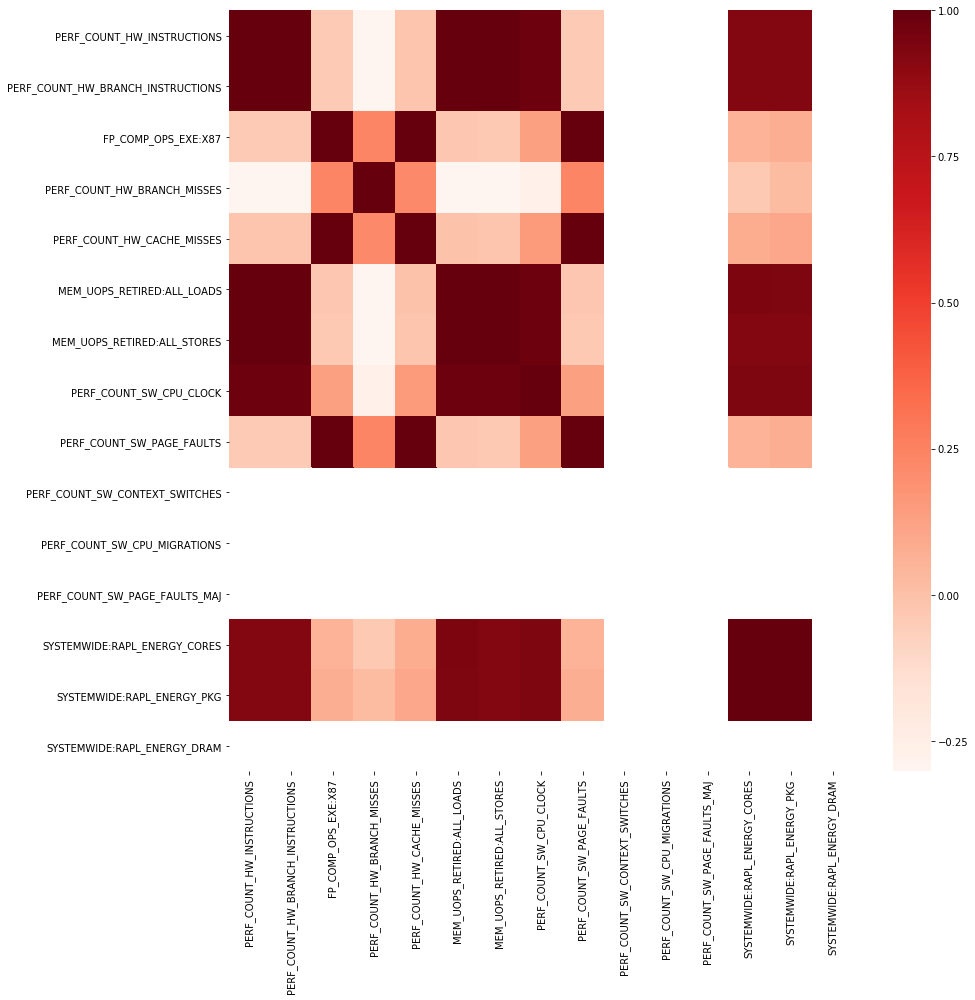

In [38]:
fig, ax= plt.subplots(figsize=(14,14))
s=list(avg_df.columns)
#.remove('time')
#.remove('energy-ram')
corr= avg_df[s].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,ax=ax,cmap='Reds')

100%|██████████| 100/100 [00:12<00:00,  8.34it/s]
/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
0it [00:00, ?it/s]

Moda shape counts 99.00%
AVG 68% samples error 0.730541050619686
AVG 99% stds error 2.191623151859058
MAX 68% stds error 9.59166304662544
MAX 99% stds error 28.77498913987632


15it [00:08,  1.89it/s]


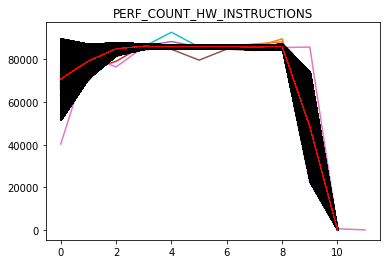

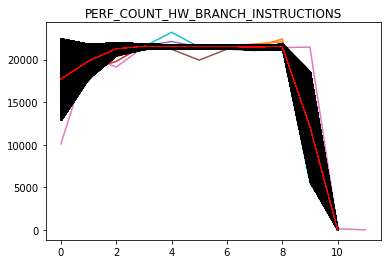

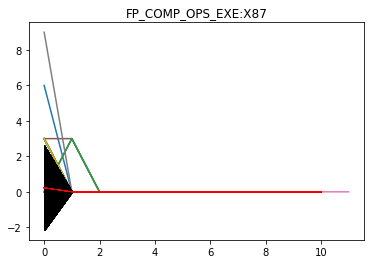

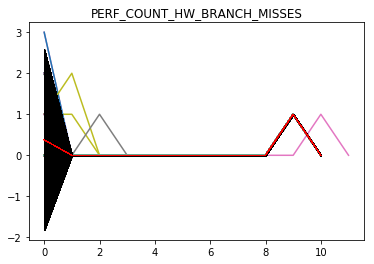

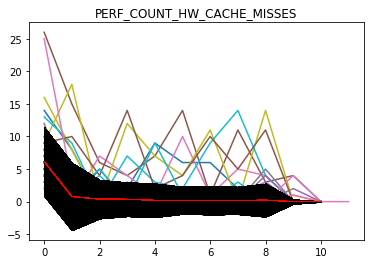

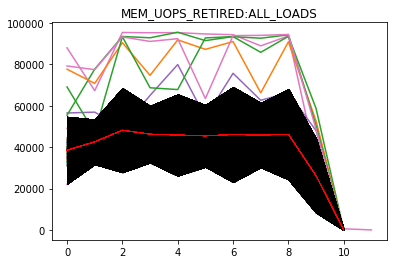

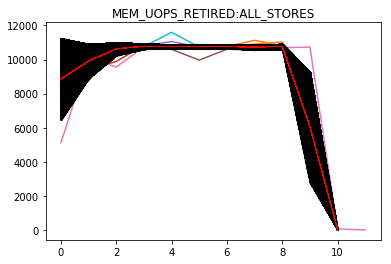

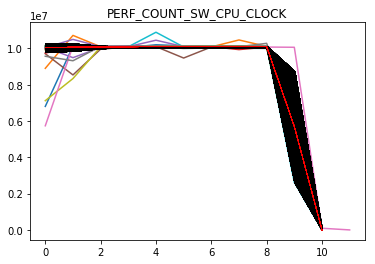

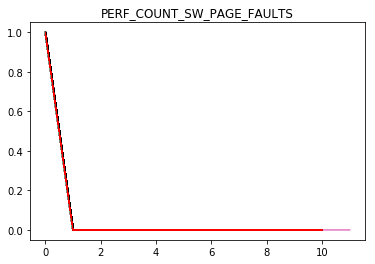

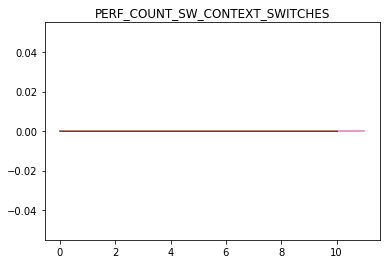

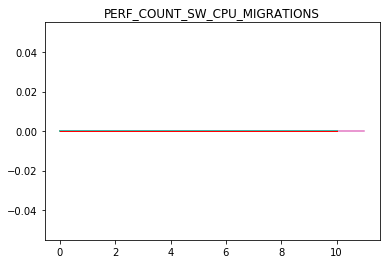

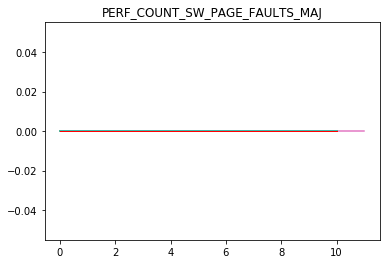

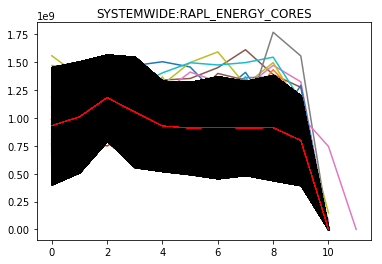

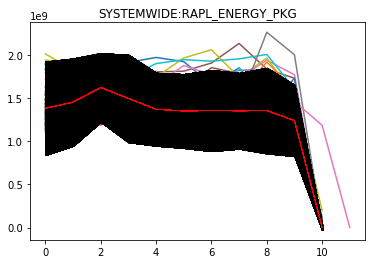

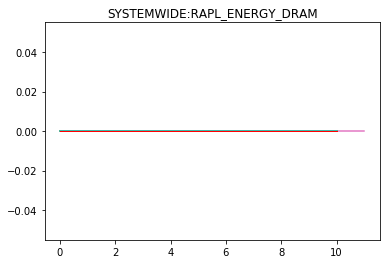

In [40]:
data= run_program(pargs=['benchs/hello'],to_monitor=to_monitor,n=100,reset_on_sample=True,sample_period=0.01)
avg_df, std_df= smooth_df(data, flat_list(to_monitor))
for i, c in tqdm(enumerate(flat_list(to_monitor))):
    plt.figure()
    for r in data:
        aux= np.array(r)
        plt.plot(aux[:,i],zorder=0)
        
        aux= avg_df[c].values
        aux_std= std_df[c].values
        plt.fill_between(np.arange(aux.shape[0]), aux-3*aux_std, aux+3*aux_std,color='k',zorder=1)
        plt.plot(aux,c='r',linewidth=0.5)
    plt.title(c)

## Supercomputer

```c++
// Supported pmu models
// ix86arch Intel X86 architectural PMU 7
// perf perf_events generic PMU 105
// perf_raw perf_events raw PMU 1
// hsw_ep Intel Haswell EP 74
// 4 pmus, supported 1279 events
```

In [73]:
dfs= None
for l in tqdm(os.listdir('data/')):
    if l.endswith('csv') and 'pw' not in l:
        pname= l.split('_')[0]
        psize= l.split('_')[1]
        df = pd.read_csv('data/'+l)
        df_pw = pd.read_csv('data/'+l.split('.')[0]+'_pw.csv')
        df= pd.concat([df,df_pw],axis=1)
        df['program']= [pname]*df.shape[0]
        df['input']= [psize]*df.shape[0]
        dfs= pd.concat([dfs,df],axis=0)
        #data= np.hstack([df,df_pw])
        #print(l)
dfs.to_csv('all.csv')

100%|██████████| 300/300 [00:07<00:00, 40.25it/s]


In [171]:
x=dfs.head(5)
x.drop(['in_cat','energy-cores'],axis=1)

,time,instructions,cache_ll,branch_instructions,branch_misses,energy-pkg,energy-ram,program,input
0,10045492,53924459,19758,2527817,23169,1.658750,0.179657,lu,SMALL
1,20222254,64130507,2594,3181821,19751,0.802124,0.079300,lu,SMALL
2,30357012,10412819,136,2035574,21200,0.845520,0.084000,lu,SMALL
3,40504492,10373776,161,2026337,23307,0.826843,0.080307,lu,SMALL
4,42406305,1707579,751,333254,4359,0.845032,0.083679,lu,SMALL


In [69]:
df= dfs[dfs['program']=='2mm']
for c in df.columns:
    print(c)
    display(df.groupby('input')[c].describe())

time


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,18360.0,9.311950e+10,5.379421e+10,10015673.0,4.652113e+10,9.310075e+10,1.396749e+11,1.862578e+11
LARGE,1330.0,6.746830e+09,3.893580e+09,10068606.0,3.378754e+09,6.746972e+09,1.011491e+10,1.346348e+10
MEDIUM,19.0,1.012657e+08,5.689382e+07,10058745.0,5.574058e+07,1.014024e+08,1.470215e+08,1.905152e+08
MINI,1.0,4.115854e+06,NaN,4115854.0,4.115854e+06,4.115854e+06,4.115854e+06,4.115854e+06
SMALL,2.0,1.173793e+07,3.096037e+06,9548698.0,1.064331e+07,1.173793e+07,1.283254e+07,1.392716e+07


instructions


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,18360.0,2.916390e+07,1.549276e+07,0.0,21554066.25,21613566.0,35238848.75,68856136.0
LARGE,1330.0,5.150492e+07,1.689144e+07,0.0,55359025.25,55493267.0,62496094.75,66106565.0
MEDIUM,19.0,3.675267e+07,2.242683e+07,10058492.0,13417528.50,41851086.0,58000618.00,61233052.0
MINI,1.0,5.008882e+06,NaN,5008882.0,5008882.00,5008882.0,5008882.00,5008882.0
SMALL,2.0,1.465829e+07,1.368290e+07,4983018.0,9820655.00,14658292.0,19495929.00,24333566.0


cache_ll


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,18360.0,431463.197821,208283.368344,0.0,194744.00,569294.0,570764.25,1088051.0
LARGE,1330.0,156650.129323,70388.596848,0.0,174601.75,175033.0,200589.50,212111.0
MEDIUM,19.0,83781.631579,78969.339878,116.0,175.50,112749.0,140181.00,187782.0
MINI,1.0,18358.000000,NaN,18358.0,18358.00,18358.0,18358.00,18358.0
SMALL,2.0,9922.000000,12822.674370,855.0,5388.50,9922.0,14455.50,18989.0


branch_instructions


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,18360.0,1.564754e+06,754763.955336,0.0,1105967.75,1109301.5,1765098.50,3444150.0
LARGE,1330.0,2.910871e+06,288501.440197,0.0,2770069.00,2776784.5,3207292.50,3392560.0
MEDIUM,19.0,2.649795e+06,408356.224774,1787033.0,2435684.50,2717538.0,2922359.00,3153498.0
MINI,1.0,7.535950e+05,NaN,753595.0,753595.00,753595.0,753595.00,753595.0
SMALL,2.0,1.348494e+06,632637.830526,901151.0,1124822.25,1348493.5,1572164.75,1795836.0


branch_misses


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,18360.0,1433.631972,4387.950366,0.0,314.00,316.0,403.00,26488.0
LARGE,1330.0,4978.081955,7980.024531,0.0,1261.00,1786.0,1790.00,24893.0
MEDIUM,19.0,14469.052632,7194.944764,6458.0,7726.00,14623.0,22549.50,22996.0
MINI,1.0,17516.000000,NaN,17516.0,17516.00,17516.0,17516.00,17516.0
SMALL,2.0,15531.500000,8758.931699,9338.0,12434.75,15531.5,18628.25,21725.0


energy-cores


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,18360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LARGE,1330.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MEDIUM,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MINI,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
SMALL,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


energy-pkg


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,18360.0,0.742805,0.054445,0.664734,0.707642,0.713257,0.748474,3.45166
LARGE,1330.0,0.836101,0.083612,0.775635,0.821716,0.824768,0.853455,3.80280
MEDIUM,19.0,0.977773,0.634964,0.786194,0.825195,0.829468,0.849091,3.59796
MINI,1.0,3.493650,NaN,3.493650,3.493650,3.493650,3.493650,3.49365
SMALL,2.0,1.942292,1.576533,0.827515,1.384904,1.942292,2.499681,3.05707


energy-ram


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,18360.0,0.082176,0.004618,0.070694,0.079666,0.081192,0.083740,0.425140
LARGE,1330.0,0.084311,0.011231,0.072754,0.079849,0.083008,0.087650,0.451096
MEDIUM,19.0,0.106320,0.080981,0.077347,0.083778,0.090149,0.090950,0.439911
MINI,1.0,0.426895,NaN,0.426895,0.426895,0.426895,0.426895,0.426895
SMALL,2.0,0.231499,0.206826,0.085251,0.158375,0.231499,0.304623,0.377747


program


,count,unique,top,freq
input,,,,
EXTRALARGE,18360,1,2mm,18360
LARGE,1330,1,2mm,1330
MEDIUM,19,1,2mm,19
MINI,1,1,2mm,1
SMALL,2,1,2mm,2


input


,count,unique,top,freq
input,,,,
EXTRALARGE,18360,1,EXTRALARGE,18360
LARGE,1330,1,LARGE,1330
MEDIUM,19,1,MEDIUM,19
MINI,1,1,MINI,1
SMALL,2,1,SMALL,2


in_cat


,count,mean,std,min,25%,50%,75%,max
input,,,,,,,,
EXTRALARGE,18360.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0
LARGE,1330.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0
MEDIUM,19.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0
MINI,1.0,5.0,NaN,5.0,5.0,5.0,5.0,5.0
SMALL,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [172]:
dfs['program'].unique()

array(['lu', 'fdtd-2d', 'gramschmidt', 'syr2k', 'gemm', '3mm', '2mm',
       'floyd-warshall', 'jacobi-2d', 'atax', 'syrk', 'trisolv', 'gemver',
       'gesummv', 'ludcmp', 'symm', 'seidel-2d', 'cholesky', 'trmm',
       'deriche', 'durbin', 'adi', 'bicg', 'heat-3d', 'nussinov',
       'doitgen', 'covariance', 'jacobi-1d', 'correlation', 'mvt'],
      dtype=object)

/home/vitor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/vitor/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/vitor/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/vitor/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/home/vitor/anaconda3/lib/python3.7/site-packages/numpy/co

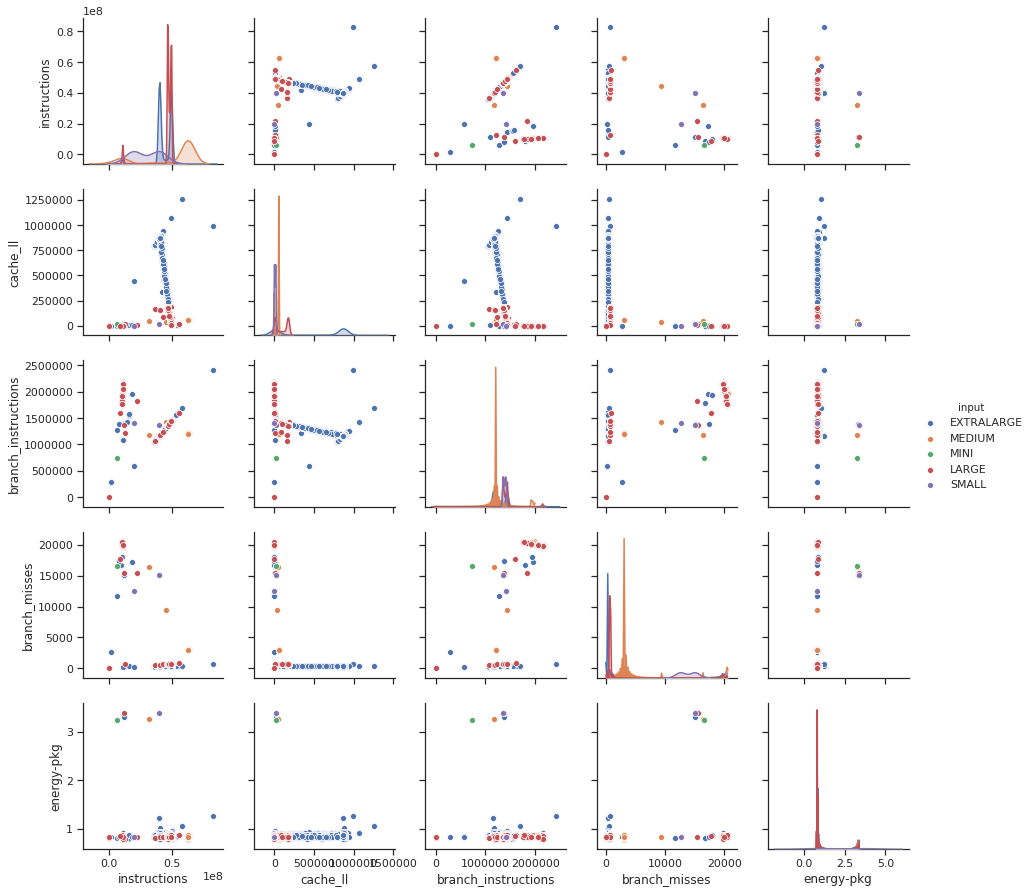

In [173]:
df= dfs[(dfs['program']=='adi')]
g = sns.pairplot(df, vars=["instructions", "cache_ll", "branch_instructions", "branch_misses", "energy-pkg"], hue='input')

## Normalization

In [76]:
cat = pd.factorize(dfs['input'])
dfs['in_cat'] = cat[0] + 1

# Min max normalization
dfs_normalized= dfs[['instructions','cache_ll','branch_instructions','branch_misses']]
dfs_normalized= (dfs_normalized-dfs_normalized.min())/(dfs_normalized.max()-dfs_normalized.min())
dfs_normalized= pd.concat( [dfs_normalized,dfs[['in_cat','program']]],axis=1)
dfs_normalized.head(5)

,instructions,cache_ll,branch_instructions,branch_misses,in_cat,program
0,0.226374,0.003014,0.155176,0.417279,1,lu
1,0.269219,0.000396,0.195324,0.355720,1,lu
2,0.043713,0.000021,0.124959,0.381817,1,lu
3,0.043549,0.000025,0.124392,0.419764,1,lu
4,0.007168,0.000115,0.020458,0.078507,1,lu


In [52]:
dfs['program'].unique()

array(['lu', 'fdtd-2d', 'gramschmidt', 'syr2k', 'gemm', '3mm', '2mm',
       'floyd-warshall', 'jacobi-2d', 'atax', 'syrk', 'trisolv', 'gemver',
       'gesummv', 'ludcmp', 'symm', 'seidel-2d', 'cholesky', 'trmm',
       'deriche', 'durbin', 'adi', 'bicg', 'heat-3d', 'nussinov',
       'doitgen', 'covariance', 'jacobi-1d', 'correlation', 'mvt'],
      dtype=object)

In [64]:
df= dfs_normalized[dfs_normalized['program']=='2mm']
X=df[['instructions','cache_ll', 'branch_instructions', 'branch_misses']].values
Y=df['in_cat']
print(df.shape)
print(df.groupby('in_cat').instructions.count())

(19712, 6)
in_cat
1        2
2       19
3     1330
4    18360
5        1
Name: instructions, dtype: int64
